In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io,data
import collections
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from data_loader.data_loader import get_patches, dataset, exp_path

Using TensorFlow backend.


[47, 66, 66, 66, 41]


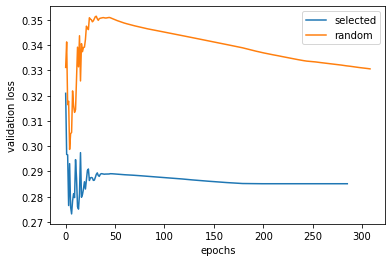

[45, 66, 66, 66, 66]


In [16]:
EXP = 'inc_S_t_0_0_200'
name = exp_path(EXP, inc=False)
history_list = np.load(name.roc_history, allow_pickle=True)
val_loss_1 = [j for i in history_list for j in i['val_loss']]
val_acc_1 = [j for i in history_list for j in i['val_acc']]
loss_1 = [j for i in history_list for j in i['loss']]
acc_1 = [j for i in history_list for j in i['acc']]
plt.plot(val_loss_1, label='selected')
print([ len(i['val_loss']) for i in history_list])
EXP = 'inc_R_t_0_0_200'
name = exp_path(EXP, inc=False)
history_list = np.load(name.roc_history, allow_pickle=True)
val_loss_2 = [j for i in history_list for j in i['val_loss']]
val_acc_2 = [j for i in history_list for j in i['val_acc']]
loss_2 = [j for i in history_list for j in i['loss']]
acc_2 = [j for i in history_list for j in i['acc']]
plt.plot(val_loss_2, label='random')
#plt.plot(val_acc)
#plt.plot(loss)
#plt.plot(acc)
plt.xlabel("epochs")
plt.ylabel("validation loss")
plt.legend()
plt.show()
print([ len(i['val_loss']) for i in history_list])

In [3]:
# Read result files and organize them
EXP = 'trans_3_0_9_200'
tumor_size = pd.read_csv("size_external.csv")
name = exp_path(EXP, inc=False)
[test_y, probs_binary, probs, patch_threshold, roc_auc] = np.load(
    name.patch_target_path, allow_pickle=True)
[train, valid, test] = np.load(name.target_path, allow_pickle=True)
print(np.shape(test_y), np.shape(test.y))

(3913,) (3913,)


Work on trans_3_0_9_200

threshold  0.16041544
rate pred 0.3375926399182213
rate valid 0.11040122668029645
rate true 0.12624584717607973
AUC  0.8236504032597074
Num tcia and msd  18 8


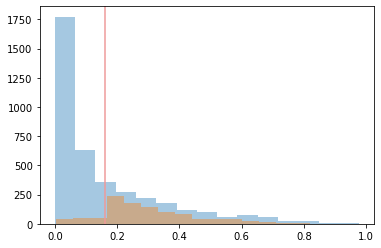

In [4]:
print("Work on " + EXP)
print("\nthreshold ", patch_threshold)
print("rate pred", probs_binary.sum()/len(probs_binary))
print("rate valid", valid.y.sum()/len(probs_binary))
print("rate true", test_y.sum()/len(probs_binary))
print("AUC ", roc_auc)
msd = sum([1 for i in range(len(test.idx)) if test.idx[i][0] == 'msd'])
print("Num tcia and msd ", msd, len(test.idx) - msd)
ax = sns.distplot(probs, bins=15, kde=False, norm_hist=False)
probs_false = [probs[i] for i in range(len(probs)) if not probs_binary[i] == test_y[i]]
ax = sns.distplot(probs_false, bins=15, kde=False, norm_hist=False)

#kde_x, kde_y = ax.lines[0].get_data()

#plotting the two lines
p1 = plt.axvline(x=patch_threshold,color='#EF9A9A')

#ax.fill_between(kde_x, kde_y, where=(kde_x<patch_threshold) , 
#                interpolate=True, color='#EF9A9A')

plt.show()

In [5]:
patient_list = []
type_list = []
for it_type, it_name, it_len in test.idx:
    patient_list.extend([it_name] * it_len)
    type_list.extend([it_type] * it_len)

In [6]:
patient_name = test.idx[15][1]
print("Work on", patient_name)
index_patient = [i for i in range(len(patient_list)) if patient_list[i] == patient_name]
cube_shape = test.coord[index_patient[0]][-3:]

patient_cube = np.zeros(cube_shape)
true_cube = np.zeros(cube_shape)
predict_cube = np.zeros(cube_shape)

identity = np.ones([1, 50, 50])
#test.X = test.X.reshape(np.shape(test.X)[:-1])
for i in index_patient:
    coord = test.coord[i]
    patient_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = test.X[i, :, :].reshape([1, 50, 50])
    true_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * test.y[i]
    predict_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * probs_binary[i]

patient_cube = (patient_cube - patient_cube.min())/(patient_cube.max() - patient_cube.min())

Work on pancreas_025.nii.gz


false  [('pancreas_247.nii.gz', 101, 0.6234567901234568), ('pancreas_016.nii.gz', 101, 0.5401069518716578)]
rate  [('pancreas_247.nii.gz', 101, 0.6234567901234568), ('pancreas_215.nii.gz', 63, 0.6176470588235294), ('pancreas_016.nii.gz', 101, 0.5401069518716578), ('pancreas_361.nii.gz', 96, 0.46153846153846156), ('pancreas_209.nii.gz', 75, 0.44642857142857145), ('pancreas_219.nii.gz', 47, 0.44339622641509435), ('pancreas_259.nii.gz', 37, 0.44047619047619047)]


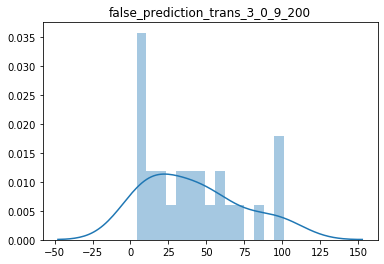

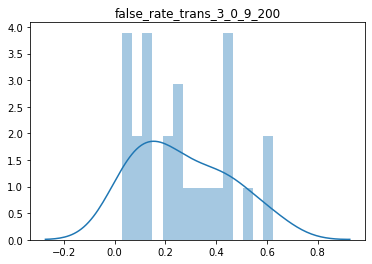

In [7]:
false_list = []
for i in range(len(test.idx)):
    filename = test.idx[i][1]
    index_patient = [i for i in range(len(patient_list)) if patient_list[i] == filename]
    cm = confusion_matrix(test.y[index_patient], probs_binary[index_patient], labels=[1, 0])
    false_list.append((filename, cm[0,1] + cm[1, 0], (cm[0,1] + cm[1, 0])/cm.sum()))
false_list = sorted(false_list, key = lambda s: s[2], reverse = True)
false_list_name = [false_list[j][0] for j in range(len(false_list))]
false_list_false = [false_list[j][1] for j in range(len(false_list))]
false_list_rate = [false_list[j][2] for j in range(len(false_list))]
print("false ", [false_list[i] for i in range(len(test.idx)) if false_list_false[i] >= 100])
print("rate ", [false_list[i] for i in range(len(test.idx)) if false_list_rate[i] >= 0.4])

sns.distplot(false_list_false, bins=15, kde=True)
plt.title('false_prediction_' + EXP)
plt.show()
sns.distplot(false_list_rate, bins=15, kde=True)

plt.title('false_rate_' + EXP)
plt.show()

In [8]:
record_size = pd.read_csv("record_size.csv")
record = [false_list[i] for i in range(len(test.idx)) if false_list_rate[i] >= 0.4]
record = [record[i] + (tumor_size['cal_size'][tumor_size.index[tumor_size['case_id'] == record[i][0]]].tolist()[0],)
          for i in range(len(record))]
record = [record[i] + (EXP,)
          for i in range(len(record))]
record = pd.DataFrame(record, columns=['case_id', 'false_num', 'false_rate', 'tumor_size', 'exp_name'])
record_size = pd.concat([record_size, record]).drop_duplicates()
#record_size = record
record_size.to_csv('record_size.csv', index=False)
#print(record_size)

In [9]:
patient_name = false_list_name[0]
print("Work on", patient_name)
index_patient = [i for i in range(len(patient_list)) if patient_list[i] == patient_name]
cube_shape = test.coord[index_patient[0]][-3:]

patient_cube = np.zeros(cube_shape)
true_cube = np.zeros(cube_shape)
predict_cube = np.zeros(cube_shape)

identity = np.ones([1, 50, 50])
#test.X = test.X.reshape(np.shape(test.X)[:-1])
for i in index_patient:
    coord = test.coord[i]
    #print(coord)
    patient_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = test.X[i, :, :].reshape([50, 50])
    true_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * test.y[i]
    predict_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * probs_binary[i]

patient_cube = (patient_cube - patient_cube.min())/(patient_cube.max() - patient_cube.min())


Work on pancreas_247.nii.gz


(3913,) (3913, 1)
[[ 373  121]
 [ 948 2471]]
0.27319192435471507
10


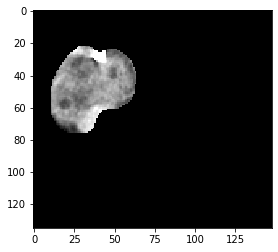

In [10]:
print(np.shape(test.y), np.shape(probs_binary))
cm = confusion_matrix(test.y, probs_binary, labels=[1, 0])
print(cm)
print((cm[0,1]+cm[1,0])/cm.sum())
index = 10
print(index)
cube_shape[2] = 1
image = patient_cube[:, :, index].reshape(cube_shape)
image = np.repeat(image, 3, axis=2)
image[:, :, 1] = image[:, :, 1]
#image[:, :, 1] = image[:, :, 1] * (1 - true_cube[:, :, index]) + true_cube[:, :, index]*120
#image[:, :, 2] = image[:, :, 2] * (1 - predict_cube[:, :, index]) + predict_cube[:, :, index]*120
plt.imshow(image)
plt.show()
    